# Network analysis notebook

This contains microbiome network analysis using Sparse Correlation Network Analysis for Compositional Data (SCNIC). This notebook does not use a QIIME environment. Instead, it uses an environment for SCNIC.

I created a L7 table with taxonomy with taxa < 100 reads removed using 
> qiime feature-table filter-features \
> --i-table tax_table.qza \
> --p-min-frequency 100 \
> --o-filtered-table L7-100-filtered-table.qza

I exported the `100_filtered-table.qza` artifact using 
> qiime tools export \
--input-path L7-100-filtered-table.qza\
--output-path L7-100

cleanup with

> mv L7-100/feature-table.biom ./L7-100-filtered-table.biom \
rm -r L7-100

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
import biom
from scipy.stats import pearsonr
from skbio.stats.composition import ancom
%matplotlib inline

In [23]:
!SCNIC_analysis.py within -i L7-100-filtered-table.biom -o SCNIC_within_output/ -m sparcc --verbose

/opt/anaconda3/envs/SCNIC-revisions/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Table loaded: 416 observations

Running SparCC iterations
	Running iteration: 1
	Running iteration: 2
	Running iteration: 3
	Running iteration: 4
	Running iteration: 5
	Running iteration: 6
	Running iteration: 7
	Running iteration: 8
	Running iteration: 9
	Running iteration: 10
	Running iteration: 11
	Running iteration: 12
	Running iteration: 13
	Running iteration: 14
	Running iteration: 15
	Running iteration: 16
	Running iteration: 17
	Running iteration: 18
	Running iteration: 19
	Running iteration: 20
	Running iteration: 21
	Running iteration: 22
	Running iteration: 23
	Running iteration: 24
	Running iteration: 25
	Running iteration: 26
	Running iteration: 27
	Running iteration: 28
	Running iteration: 29
	Running iteration: 30
	Running iterat

In [24]:
!SCNIC_analysis.py modules \
-i SCNIC_within_output/correls.txt \
-o SCNIC_modules_output/ \
--method naive \
--min_r .35 \
--table L7-100-filtered-table.biom \
--verbose

/opt/anaconda3/envs/SCNIC-revisions/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
correls.txt read
Modules Formed
number of modules: 118
number of observations in modules: 1070

otu table read
Table Collapsed
collapsed Table Observations: 220

Network Generated
number of nodes: 381
number of edges: 1995


## Load in data

In [2]:
G = nx.read_gml("SCNIC_modules_output/correlation_network.gml")
modules = pd.read_csv("SCNIC_modules_output/modules.txt", header=None, sep="\t", index_col=0)

In [3]:
# only consider modules with >3 members
filt_modules = modules.loc[modules.notna().sum(axis=1)>3] 

In [4]:
modules_melted = pd.melt(filt_modules.reset_index(), id_vars=0)
modules_melted.columns = ["module", "IGNORE","taxon"]
modules_melted = modules_melted.set_index("taxon")

## Draw network

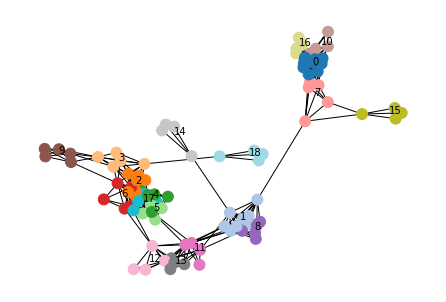

In [21]:
pos = nx.spring_layout(G)

color_list = []
to_remove = []
for node in G:
    if node in modules_melted.index:
        color_list.append(int(modules_melted.loc[node,"module"].split("_")[1]))
    else:
        to_remove.append(node)

for node in to_remove:
    G.remove_node(node)
        
        
cmap = cm.get_cmap('tab20')

nx.draw(G, pos, cmap=cmap, node_color=color_list, node_size=120)

for module in filt_modules.index:
    mod_contents = modules.loc[module].dropna().to_list()
    avg_x = sum([pos[node][0] for node in mod_contents])/len(mod_contents)
    avg_y = sum([pos[node][1] for node in mod_contents])/len(mod_contents)
    plt.annotate(module.split("_")[1],
                xy=(avg_x,avg_y))

plt.savefig("figures/SCNIC_Network_drawing.svg", transparent=True, bbox_inches="tight")
plt.show()

## Testing

In [5]:
collapsed_table = biom.load_table("SCNIC_modules_output/collapsed.biom").to_dataframe()
modules_table = collapsed_table.loc[modules.index].T
modules_table = modules_table.apply(lambda x: x+0.01)

In [6]:
metadata = pd.read_csv("metadata.txt", sep="\t", index_col="SampleID")
metadata = metadata.loc[modules_table.index]

In [7]:
res, percentiles = ancom(modules_table,metadata["HIV"])

In [8]:
res.loc[res["Reject null hypothesis"]==True]

,W,Reject null hypothesis
0,,
module_17,84,True
module_44,78,True


2 significantly different modules, based on ANCOM (analysis of communities of microbiomes). Plotting below:

In [9]:
modules_table_mat = np.matrix(modules_table)
modules_table_mat /= np.sum(modules_table_mat,axis=1)
modules_composition = pd.DataFrame(modules_table_mat, index=modules_table.index, 
                                   columns=modules_table.columns)

In [10]:
sns.set_context("talk")

/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_44575/1242327758.py:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.swarmplot(x=metadata["HIV"],
/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_44575/1242327758.py:7: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  ax = sns.swarmplot(x=metadata["HIV"],


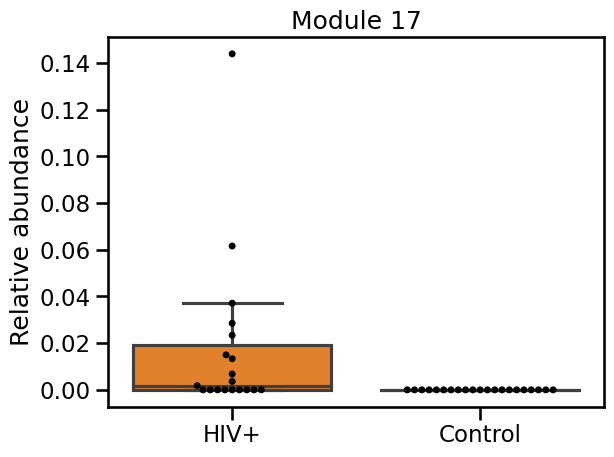

In [11]:
ax = sns.boxplot(x=metadata["HIV"], 
            y=modules_composition["module_17"],
            order=["Yes", "No"],
            palette=["tab:orange", "tab:blue"],
            showfliers=False)

ax = sns.swarmplot(x=metadata["HIV"], 
                  y=modules_composition["module_17"],
                  order=["Yes", "No"],
                  palette=["black"],
                  ax=ax)
ax.set_title("Module 17")
ax.set_ylabel("Relative abundance")
ax.set(xlabel=None, xticklabels=["HIV+", "Control"])

plt.savefig("figures/module_17_HIV_boxplot.svg", transparent=True, bbox_inches="tight")
plt.show()

In [12]:
for tax in modules.loc["module_17"].dropna():
    print(tax)

d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;__
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Alloprevotella;s__Prevotellaceae_bacterium
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__uncultured;g__uncultured;s__gut_metagenome
d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Libanicoccus;s__Libanicoccus_massiliensis


for module in modules_composition.columns:
    r, p = pearsonr(modules_composition[module],
                   metadata["Fibroscan"])
    print(f"{module} r = {r}, p = {p}")

/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_44575/2232587424.py:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.swarmplot(x=metadata["HIV"],
/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_44575/2232587424.py:7: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  ax = sns.swarmplot(x=metadata["HIV"],


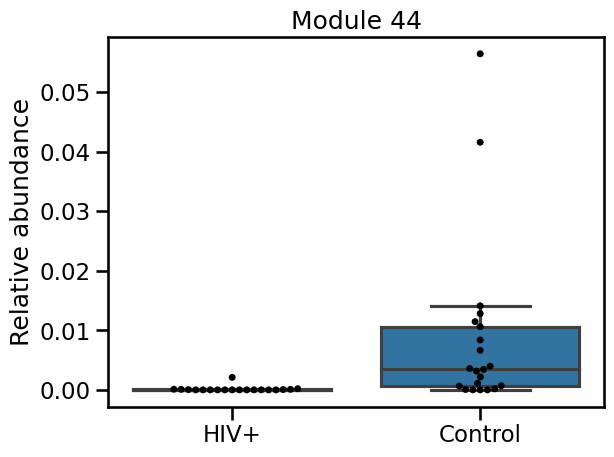

In [13]:
ax = sns.boxplot(x=metadata["HIV"], 
            y=modules_composition["module_44"],
            order=["Yes", "No"],
            palette=["tab:orange", "tab:blue"],
            showfliers=False)

ax = sns.swarmplot(x=metadata["HIV"], 
                  y=modules_composition["module_44"],
                  order=["Yes", "No"],
                  palette=["black"],
                  ax=ax)
ax.set_title("Module 44")
ax.set_ylabel("Relative abundance")
ax.set(xlabel=None, xticklabels=["HIV+", "Control"])

plt.savefig("figures/module_44_HIV_boxplot.svg", transparent=True, bbox_inches="tight")
plt.show()

In [15]:
for tax in modules.loc["module_44"].dropna():
    print(tax)

d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_ventriosum_group;s__uncultured_Lachnospiraceae
d__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium;__


This analysis is also showing an increase in prevotella-rich groups and a decrease in Lachnospiraceae (much like the gneiss results)